In [71]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split


from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_curve, auc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# data = pd.read_csv("transformed_dataset.csv")
# data['NoShow'].value_counts()

In [3]:

class ToTensor:

    def __call__(self, data):
        if not isinstance(data, tuple):
            return torch.from_numpy(data)
        X, y = data
        return torch.from_numpy(X), torch.from_numpy(y)


class MyData(Dataset):

    def __init__(self, transforms=None):
        data = pd.read_csv("transformed_dataset.csv")
        self.X = data.drop(columns=['NoShow']).to_numpy(dtype=np.float32)
        self.y = data['NoShow'].to_numpy(dtype=np.float32).reshape(-1, 1)
        self.transforms = transforms

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, index):
        sample = self.X[index], self.y[index]

        if self.transforms:
            sample = self.transforms(sample)

        return sample

class FocalLoss(nn.Module):

    def __init__(self, alpha=0.5, gamma=2):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        #input is logits, before applying sigmoid
        bce_loss = nn.functional.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        p_t = torch.exp(-bce_loss)

        focal_loss = (1-p_t)**self.gamma * bce_loss

        weights = self.alpha*targets  + (1-self.alpha)*(1-targets)
        weights = weights.to(focal_loss.device)

        return (focal_loss*weights).mean()
        

        

In [7]:
data = MyData(transforms=ToTensor())

input_size = data[0][0].shape[0] #first training example, get features, then get number of features
output_size= 1

train, test = random_split(data, [0.7, 0.3])
train_loader = DataLoader(train, batch_size=256, shuffle=True)
test_loader = DataLoader(test, batch_size=len(test), shuffle=False)
# data[0][0].shape


In [53]:
model = nn.Sequential(
    nn.Linear(input_size, 64),
    nn.Dropout(p=0.4),
    nn.ReLU(),
    nn.Linear(64, 32),
    # nn.Dropout(p=0.3),
    nn.ReLU(),
    nn.Linear(32, 16),
    nn.ReLU(),
    nn.Linear(16, 16),
    nn.ReLU(),
    nn.Linear(16, 8),
    nn.ReLU(),
    nn.Linear(8, 8),
    nn.ReLU(),
    nn.Linear(8, 1),
)

# loss = nn.BCEWithLogitsLoss(weight=torch.Tensor([3.0]))
loss = FocalLoss(alpha=0.6, gamma=2.0)
optimizer = optim.Adam(model.parameters(), lr=1e-3) #weight_decay=1e-2)

In [54]:
with torch.no_grad():
    test_output = torch.sigmoid(model(x_test))
    
    precision, recall, thresholds = precision_recall_curve(y_test.cpu(), test_output.cpu())
    print("max-", f1_score(y_test.cpu(), (test_output>0.5).cpu(), average='weighted'))
            
    # print(f"")
    maxf1 = 2*np.max(precision*recall/(precision+recall+1e-9))
    print(maxf1)
    print(auc(recall, precision))

max- 0.06614042245198097
0.3321512107695665
0.23541105789666358


In [55]:
for epoch in range(5):
    total_training_loss = 0
    
    for iteration, (features, labels) in enumerate(train_loader):

        output = model(features)
        loss_value = loss(output, labels)

        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()

        total_training_loss += loss_value.item()

        if (iteration%50==0):
            x_test, y_test = next(iter(test_loader))
            with torch.no_grad():
                test_output = torch.sigmoid(model(x_test))
                
            precision, recall, thresholds = precision_recall_curve(y_test, test_output)
            # print(f"")
            maxf1 = 2*np.max(precision*recall/(precision+recall+1e-9))
            
            
            print(f"Epoch: {epoch+1}, iteration: {iteration+1}, loss: {loss_value.item():.4f}, Test PR-AUC: {auc(recall, precision):.4f}, max-f1: {maxf1:.4f}")
            

    print(f"overall epoch {epoch+1} loss: {total_training_loss/iteration}")
    
        

Epoch: 1, iteration: 1, loss: 0.0932, Test PR-AUC: 0.2285, max-f1: 0.3322
Epoch: 1, iteration: 51, loss: 0.0760, Test PR-AUC: 0.1508, max-f1: 0.3321
Epoch: 1, iteration: 101, loss: 0.0684, Test PR-AUC: 0.2966, max-f1: 0.4259
Epoch: 1, iteration: 151, loss: 0.0576, Test PR-AUC: 0.3031, max-f1: 0.4258
Epoch: 1, iteration: 201, loss: 0.0550, Test PR-AUC: 0.3061, max-f1: 0.4284
Epoch: 1, iteration: 251, loss: 0.0612, Test PR-AUC: 0.3128, max-f1: 0.4292
Epoch: 1, iteration: 301, loss: 0.0585, Test PR-AUC: 0.3137, max-f1: 0.4303
overall epoch 1 loss: 0.065784516183055
Epoch: 2, iteration: 1, loss: 0.0581, Test PR-AUC: 0.3176, max-f1: 0.4312
Epoch: 2, iteration: 51, loss: 0.0587, Test PR-AUC: 0.3163, max-f1: 0.4315
Epoch: 2, iteration: 101, loss: 0.0584, Test PR-AUC: 0.3178, max-f1: 0.4314
Epoch: 2, iteration: 151, loss: 0.0594, Test PR-AUC: 0.3168, max-f1: 0.4337
Epoch: 2, iteration: 201, loss: 0.0595, Test PR-AUC: 0.3211, max-f1: 0.4348
Epoch: 2, iteration: 251, loss: 0.0559, Test PR-AUC: 0

max- 0.7480823543336111
0.4367061627529884
0.3303866472755821


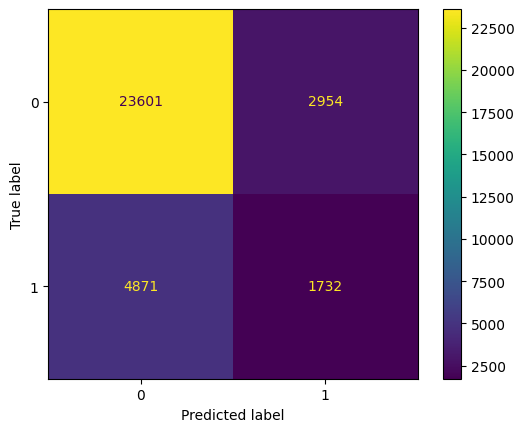

In [74]:
with torch.no_grad():
    test_output = torch.sigmoid(model(x_test))
    
    precision, recall, thresholds = precision_recall_curve(y_test.cpu(), test_output.cpu())
    print("max-", f1_score(y_test.cpu(), (test_output>0.47797).cpu(), average='weighted'))
            

    conf_matrix = confusion_matrix(y_test.cpu(), (test_output>0.47797).cpu())

    ConfusionMatrixDisplay(confusion_matrix=conf_matrix).plot()
    
    
    maxf1 = 2*np.max(precision*recall/(precision+recall+1e-9))
    print(maxf1)
    print(auc(recall, precision))

    plt.show()

In [32]:
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_curve

# f1_score(y_test, y_pred>=0.365, average='weighted')

In [10]:
import psutil
psutil.virtual_memory().used

14527045632

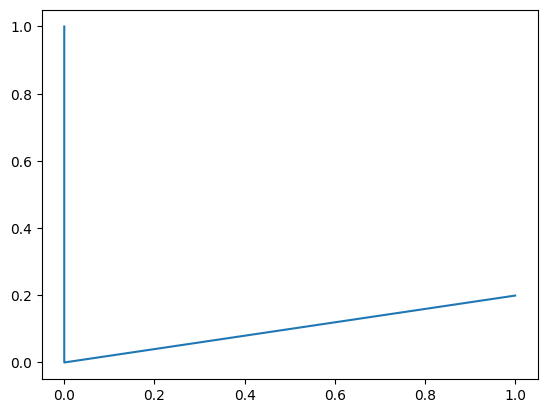

In [46]:
plt.plot(recall, precision)

In [12]:
### THIS PART OF CODE WAS GENERATED USING GEMINI

import psutil
import os

# Get the current process
process = psutil.Process(os.getpid())

# Get memory info for this specific process
# .rss (Resident Set Size) is often a good measure for actual physical RAM used by the process.
# .vms (Virtual Memory Size) is the total virtual address space, can be much larger.
mem_info = process.memory_info()
rss_bytes = mem_info.rss
vms_bytes = mem_info.vms

print(f"Current script - RSS: {rss_bytes / (1024 * 1024):.2f} MB") # Resident Set Size
print(f"Current script - VMS: {vms_bytes / (1024 * 1024):.2f} MB") # Virtual Memory Size

# For total system usage (what you were using before)
total_system_used_bytes = psutil.virtual_memory().used
print(f"Total system RAM used: {total_system_used_bytes / (1024 * 1024 * 1024):.2f} GB")

Current script - RSS: 629.91 MB
Current script - VMS: 1796.74 MB
Total system RAM used: 13.53 GB
